In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

# Load data set
mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist['data'] / 255, mnist['target']

# Split the data set into training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 / 3, random_state=42)
n = X_train.shape[0]
print(f"Rows to train: {n}")
m = X_test.shape[0]
print(f"Rows to test: {m}")

# Neural network parameters
L = 0.1
num_iterations = 3_000
batch_size = 32_768

user_choice = input("Load old parameters (c) or train from scratch (e)?")

#! Initializing the neural network parameters =============================================== 
# If you want to know which graph it corresponds to, look at the graph title.

#model_params_file = os.path.join('Weights_&_Bias', 'params_0.npz') # Final precision of test: 67.2851%, Final Precision of train: 72.3632%
#model_params_file = os.path.join('Weights_&_Bias', 'params_1.npz') # Final precision of test: 90.5761%, Final Precision of train: 97.9492%
#model_params_file = os.path.join('Weights_&_Bias', 'params_2.npz') # Final precision of test: 44.2382%, Final Precision of train: 44.0429%
#model_params_file = os.path.join('Weights_&_Bias', 'params_3.npz') # Final precision of test: 90.9175%, Final Precision of train: 100.0000%, created from params_1
#model_params_file = os.path.join('Weights_&_Bias', 'params_4.npz') # Final precision of test: 91.2597%, Final Precision of train: 100.0000%, created from params_3
#model_params_file = os.path.join('Weights_&_Bias', 'params_5.npz') # Final precision of test: 93.8964%, Final Precision of train: 100.0000%, created from params_4
#model_params_file = os.path.join('Weights_&_Bias', 'params_6.npz') # Final precision of test: 94.8730%, Final Precision of train: 100.0000%, created from params_5
#model_params_file = os.path.join('Weights_&_Bias', 'params_7.npz') # Final precision of test: 70.3125%, Final Precision of train: 100.0000%, L = 0.01, batch_size = 128, num_iterations = 10_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_8.npz') # Final precision of test: 76.5625%, Final Precision of train: 100.0000%, L = 0.02, batch_size = 256, num_iterations = 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_9.npz') # Final precision of test: 86.7188%, Final Precision of train: 99.1211%, L = 0.02, batch_size = 1024, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_10.npz') # Final precision of test: 87.9883%, Final Precision of train: 96.7285% L = 0.03, batch_size = 2048, num_iterations= 3_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_11.npz') # Final precision of test: 90.6982%, Final Precision of train: 98.9014% L = 0.03, batch_size = 4096, num_iterations= 6_000 (Iter 5600, Precision of test: 90.7471%, Precision of train: 98.6328%)
#model_params_file = os.path.join('Weights_&_Bias', 'params_12.npz') # Final precision of test: 84.3750%, Final Precision of train: 100.0000% L = 0.02, batch_size = 512, num_iterations= 6_000 (Iter 4000, Precision of test: 84.9609%, Precision of train: 100.0000%)
#model_params_file = os.path.join('Weights_&_Bias', 'params_13.npz') # Final precision of test: 93.6646%, Final Precision of train: 98.7671% L = 0.03, batch_size = 8_192, num_iterations= 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_14.npz') # Final precision of test: 94.0552%, Final Precision of train: 99.7314% L = 0.08, batch_size = 8_192, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_15.npz') # ""Final precision of test: 96.0000%, Final Precision of train: 97.0000%"" L = 0.1, batch_size = 16_384, num_iterations= 4_000
model_params_file = os.path.join('Weights_&_Bias', 'params_16.npz') # Final precision of test: 96.4650%, Final Precision of train: 97.9550% L = 0.1, batch_size = 32_768, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_17.npz') # Final precision of test: 96.9700%, Final Precision of train: 98.9100% L = 0.1, batch_size = 32_768, num_iterations= 3_000 created from params_16

#! Initializing the neural network parameters =============================================== 

# Initialize weights and bias
if user_choice.lower() == 'c' and os.path.exists(model_params_file):
    # Load weights and biases from the .npz file
    try:
        params = np.load(model_params_file)
        w_1 = params['w_1']
        b_1 = params['b_1']
        w_2 = params['w_2']
        b_2 = params['b_2']
        w_3 = params['w_3']
        b_3 = params['b_3']
        print(f"Parameters loaded from '{model_params_file}'.")
    except Exception as e:
        print(f"Error loading parameters: {e}")
        np.random.seed(13)
        
        w_1 = np.random.randn(256, 784) * 0.01
        w_2 = np.random.randn(128, 256) * 0.01
        w_3 = np.random.randn(10, 128) * 0.01
        b_1 = np.random.rand(256, 1)
        b_2 = np.random.rand(128, 1)
        b_3 = np.random.rand(10, 1)
        print("Randomly initialized parameters.")
else:
    np.random.seed(13)
    w_1 = np.random.randn(256, 784) * 0.01
    w_2 = np.random.randn(128, 256) * 0.01
    w_3 = np.random.randn(10, 128) * 0.01
    b_1 = np.random.rand(256, 1)
    b_2 = np.random.rand(128, 1)
    b_3 = np.random.rand(10, 1)
    print("Randomly initialized parameters.")

# Activation functions
relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(X):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Derivatives of the activation functions
d_relu = lambda x: x > 0

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y.astype(int), np.arange(Y.size)] = 1
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    # Convert Y to one-hot encoding
    one_hot_Y = one_hot(Y, A3.shape[0])
    
    dCE_dZ3 = A3 - one_hot_Y
    dZ3_dW3 = A2  
    dZ3_dB3 = 1
    dZ3_dA2 = w_3
    dA2_dZ2 = d_relu(Z2)
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dZ2_dA1 = w_2
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    # Calculate gradients for W3 and b3
    dCE_dW3 = dCE_dZ3 @ dZ3_dW3.T / X.shape[1]
    dCE_dB3 = np.sum(dCE_dZ3, axis=1, keepdims=True) / X.shape[1]

    dCE_dA2 = dZ3_dA2.T @ dCE_dZ3
    dCE_dZ2 = dCE_dA2 * dA2_dZ2

    # Calculate gradients for W2 and b2
    dCE_dW2 = dCE_dZ2 @ dZ2_dW2.T / X.shape[1]
    dCE_dB2 = np.sum(dCE_dZ2, axis=1, keepdims=True) / X.shape[1]

    dCE_dA1 = dZ2_dA1.T @ dCE_dZ2
    dCE_dZ1 = dCE_dA1 * dA1_dZ1

    # Calculate gradients for W1 and b1
    dCE_dW1 = dCE_dZ1 @ dZ1_dW1.T / X.shape[1]
    dCE_dB1 = np.sum(dCE_dA1, axis=1, keepdims=True) / X.shape[1]

    return dCE_dW1, dCE_dB1, dCE_dW2, dCE_dB2, dCE_dW3, dCE_dB3

def calculate_accuracy(X_data, Y_data, sample_size):
    idx = np.random.choice(len(X_data), sample_size, replace=False)
    X_sample = X_data.iloc[idx].to_numpy().transpose()  # Transpose to (784, batch_size)
    Y_sample = Y_data.iloc[idx].to_numpy()
    _, _, _, _, _, A3 = forward_prop(X_sample)
    predictions = np.argmax(A3, axis=0)
    accuracy = np.mean(predictions == Y_sample.astype(int))
    return accuracy

# Gradient descent training
accuracy_train_l = []
accuracy_test_l = []
for i in tqdm(range(num_iterations), desc="Training", unit="iteration"):
    np.random.seed(13)
    idx = np.random.choice(n, batch_size, replace=False)
    X_train_batch = X_train.iloc[idx].to_numpy().transpose()  # Transpose to (784, batch_size)
    Y_train_batch = Y_train.iloc[idx].to_numpy()
    #print(X_train_batch.shape)
    #print(Y_train_batch.shape)

    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_train_batch)

    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_train_batch, Y_train_batch)

    # Update weights and bias
    w_1 -= L * dW1
    b_1 -= L * dB1
    w_2 -= L * dW2
    b_2 -= L * dB2
    w_3 -= L * dW3
    b_3 -= L * dB3

    sample_size = 1000
    accuracy_test = calculate_accuracy(X_test, Y_test, sample_size)
    accuracy_train = calculate_accuracy(X_train, Y_train, sample_size)
    accuracy_test_l.append(accuracy_test)
    accuracy_train_l.append(accuracy_train)

    # When you look at the accuracy of test and train it is better to use large sample_size because if you use small sample_size like 500 the accuracy can be off by 3.00% or more.
    if i % 200 == 0:
        print(f"Iter {i}, Approx accuracy: test(sample): {accuracy_test * 100:.4f}%, train(sample): {accuracy_train * 100:.4f}%") # Remember that as the sample is 1000 it is not exact but it is quite close, that's also why the numbers are so round.
    if i % 1000 == 0:
        sample_size = 20_000
        accuracy_test = calculate_accuracy(X_test, Y_test, sample_size)
        accuracy_train = calculate_accuracy(X_train, Y_train, sample_size)
        print(f"Iter {i}, Precision of test(sample): {accuracy_test * 100:.4f}%, Precision of train(sample): {accuracy_train * 100:.4f}%")

sample_size = 20_000
accuracy_test = calculate_accuracy(X_test, Y_test, sample_size)
accuracy_train = calculate_accuracy(X_train, Y_train, sample_size)
print(f"Final precision of test: {accuracy_test * 100:.4f}%, Final Precision of train: {accuracy_train * 100:.4f}%")


# Save Weights and Bias ===================================================================================================================================================

folder_name = "Weights_&_Bias"
os.makedirs(folder_name, exist_ok=True)

user_choice = input("Save training data? (y/n) ")

if user_choice.lower() == 'y':
    i = 0
    new_model_params_file = os.path.join(folder_name, f"params_{i}.npz") # se fija si existe el nombre y de ahi le cambia al nombre de abajo hasta que no exista
    while os.path.exists(new_model_params_file):
        i += 1
        new_model_params_file = os.path.join(folder_name, f"params_{i}.npz")

    np.savez(new_model_params_file, w_1=w_1, b_1=b_1, w_2=w_2, b_2=b_2, w_3=w_3, b_3=b_3)
    print(f"Parameters stored in '{new_model_params_file}'.")
elif user_choice.lower() == 'n':
    print("Training data were not saved.")
else:
    print("Invalid option. Training data was not saved.")


Rows to train: 46666
Rows to test: 23334
Parametros cargados desde 'Weights_&_Bias\params_16.npz'.


Training:   0%|          | 0/3000 [00:00<?, ?iteration/s]

Iter 0, Approx accuracy: test(sample): 96.7000%, train(sample): 97.6000%


Training:   0%|          | 1/3000 [00:01<1:00:44,  1.22s/iteration]

Iter 0, Precision of test(sample): 96.4700%, Precision of train(sample): 97.9550%


Training:   7%|▋         | 201/3000 [02:35<34:22,  1.36iteration/s]

Iter 200, Approx accuracy: test(sample): 96.7000%, train(sample): 98.0000%


Training:  13%|█▎        | 401/3000 [05:21<37:55,  1.14iteration/s]

Iter 400, Approx accuracy: test(sample): 96.7000%, train(sample): 98.1000%


Training:  20%|██        | 601/3000 [08:25<32:01,  1.25iteration/s]

Iter 600, Approx accuracy: test(sample): 96.8000%, train(sample): 98.1000%


Training:  27%|██▋       | 801/3000 [11:14<29:20,  1.25iteration/s]

Iter 800, Approx accuracy: test(sample): 96.8000%, train(sample): 98.2000%


Training:  33%|███▎      | 1000/3000 [13:58<26:14,  1.27iteration/s]

Iter 1000, Approx accuracy: test(sample): 96.8000%, train(sample): 98.4000%


Training:  33%|███▎      | 1001/3000 [13:59<31:32,  1.06iteration/s]

Iter 1000, Precision of test(sample): 96.7150%, Precision of train(sample): 98.4400%


Training:  40%|████      | 1201/3000 [16:49<25:24,  1.18iteration/s]

Iter 1200, Approx accuracy: test(sample): 96.8000%, train(sample): 98.3000%


Training:  47%|████▋     | 1401/3000 [19:46<22:53,  1.16iteration/s]

Iter 1400, Approx accuracy: test(sample): 97.0000%, train(sample): 98.5000%


Training:  53%|█████▎    | 1601/3000 [22:43<19:08,  1.22iteration/s]

Iter 1600, Approx accuracy: test(sample): 97.2000%, train(sample): 98.6000%


Training:  60%|██████    | 1801/3000 [25:27<15:31,  1.29iteration/s]

Iter 1800, Approx accuracy: test(sample): 97.2000%, train(sample): 98.6000%


Training:  67%|██████▋   | 2000/3000 [28:00<12:51,  1.30iteration/s]

Iter 2000, Approx accuracy: test(sample): 97.1000%, train(sample): 98.6000%


Training:  67%|██████▋   | 2001/3000 [28:01<15:11,  1.10iteration/s]

Iter 2000, Precision of test(sample): 96.9300%, Precision of train(sample): 98.7800%


Training:  73%|███████▎  | 2201/3000 [30:35<10:03,  1.32iteration/s]

Iter 2200, Approx accuracy: test(sample): 97.1000%, train(sample): 98.6000%


Training:  80%|████████  | 2401/3000 [33:04<07:22,  1.35iteration/s]

Iter 2400, Approx accuracy: test(sample): 97.1000%, train(sample): 98.7000%


Training:  87%|████████▋ | 2601/3000 [35:33<04:47,  1.39iteration/s]

Iter 2600, Approx accuracy: test(sample): 97.1000%, train(sample): 98.8000%


Training:  93%|█████████▎| 2801/3000 [38:04<02:48,  1.18iteration/s]

Iter 2800, Approx accuracy: test(sample): 97.1000%, train(sample): 98.8000%


Training: 100%|██████████| 3000/3000 [40:44<00:00,  1.23iteration/s]


Final precision of test: 96.9700%, Final Precision of train: 98.9100%
Parametros guardados en 'Weights_&_Bias\params_17.npz'.


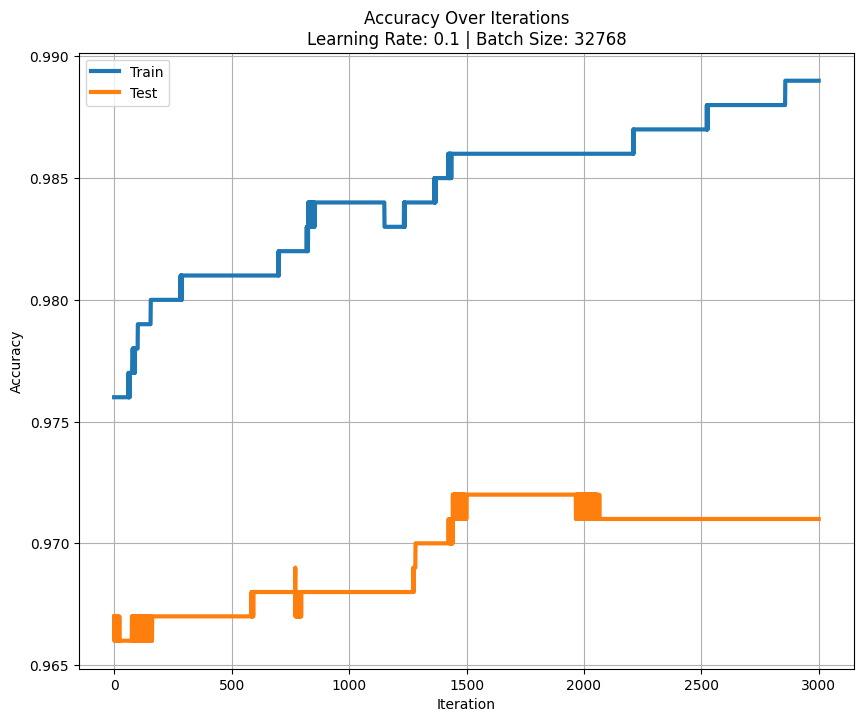

In [3]:
def accuracy_graphic(L, iters, batch, train_l, test_l):

    folder_name = "graphs"
    os.makedirs(folder_name, exist_ok=True)

    fmt_train = {'color': 'tab:blue', 'ls': 'solid', 'lw': 3}
    fmt_test = {'color': 'tab:orange', 'ls': 'solid', 'lw': 3}
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(range(iters), train_l, label='Train', **fmt_train)
    ax.plot(range(iters), test_l, label='Test', **fmt_test)
    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy Over Iterations\nLearning Rate: {L} | Batch Size: {batch}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Accuracy')

    # Save the figure in the "graphs" folder
    file_path = os.path.join(folder_name, f"accuracy_{L}_{batch}.png")
    plt.savefig(file_path)
    plt.show()

accuracy_graphic(L, num_iterations, batch_size, accuracy_train_l, accuracy_test_l)


Draw a number and press 'Enter' to predict it.
Parameters loaded from 'Weights_&_Bias\params_15.npz'.
The image is probably a: 4


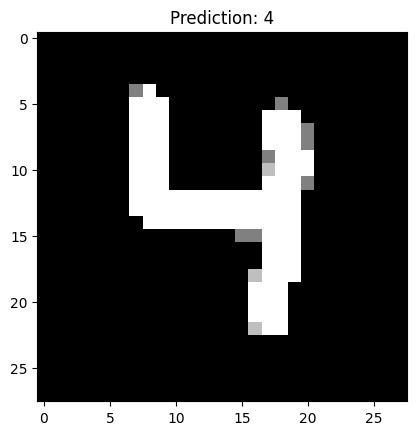

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

#! Initializing the neural network parameters =============================================== 
# If you want to know which graph it corresponds to, look at the graph title.

#model_params_file = os.path.join('Weights_&_Bias', 'params_0.npz') # Final test accuracy: 67.2851%, Final train accuracy: 72.3632%
#model_params_file = os.path.join('Weights_&_Bias', 'params_1.npz') # Final test accuracy: 90.5761%, Final train accuracy: 97.9492%
#model_params_file = os.path.join('Weights_&_Bias', 'params_2.npz') # Final test accuracy: 44.2382%, Final train accuracy: 44.0429%
#model_params_file = os.path.join('Weights_&_Bias', 'params_3.npz') # Final test accuracy: 90.9175%, Final train accuracy: 100.0000%, created from params_1
#model_params_file = os.path.join('Weights_&_Bias', 'params_4.npz') # Final test accuracy: 91.2597%, Final train accuracy: 100.0000%, created from params_3
#model_params_file = os.path.join('Weights_&_Bias', 'params_5.npz') # Final test accuracy: 93.8964%, Final train accuracy: 100.0000%, created from params_4
#model_params_file = os.path.join('Weights_&_Bias', 'params_6.npz') # Final test accuracy: 94.8730%, Final train accuracy: 100.0000%, created from params_5
#model_params_file = os.path.join('Weights_&_Bias', 'params_7.npz') # Final test accuracy: 70.3125%, Final train accuracy: 100.0000%, L = 0.01, batch_size = 128, num_iterations = 10_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_8.npz') # Final test accuracy: 76.5625%, Final train accuracy: 100.0000%, L = 0.02, batch_size = 256, num_iterations = 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_9.npz') # Final test accuracy: 86.7188%, Final train accuracy: 99.1211%, L = 0.02, batch_size = 1024, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_10.npz') # Final test accuracy: 87.9883%, Final train accuracy: 96.7285% L = 0.03, batch_size = 2048, num_iterations= 3_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_11.npz') # Final test accuracy: 90.6982%, Final train accuracy: 98.9014% L = 0.03, batch_size = 4096, num_iterations= 6_000 (Iter 5600, Test accuracy: 90.7471%, Train accuracy: 98.6328%)
#model_params_file = os.path.join('Weights_&_Bias', 'params_12.npz') # Final test accuracy: 84.3750%, Final train accuracy: 100.0000% L = 0.02, batch_size = 512, num_iterations= 6_000 (Iter 4000, Test accuracy: 84.9609%, Train accuracy: 100.0000%)
#model_params_file = os.path.join('Weights_&_Bias', 'params_13.npz') # Final test accuracy: 93.6646%, Final train accuracy: 98.7671% L = 0.03, batch_size = 8_192, num_iterations= 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_14.npz') # Final test accuracy: 94.0552%, Final train accuracy: 99.7314% L = 0.08, batch_size = 8_192, num_iterations= 4_000
model_params_file = os.path.join('Weights_&_Bias', 'params_15.npz') # ""Final test accuracy: 96.0000%, Final train accuracy: 97.0000%"" L = 0.1, batch_size = 16_384, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_16.npz') # Final test accuracy: 96.4650%, Final train accuracy: 97.9550% L = 0.1, batch_size = 32_768, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_17.npz') # Final test accuracy: 96.9700%, Final train accuracy: 98.9100% L = 0.1, batch_size = 32_768, num_iterations= 3_000 created from params_16

#! Initializing the neural network parameters =============================================== 

def load_model_params(file_path):
    if os.path.exists(file_path):
        try:
            params = np.load(file_path)
            w_1 = params['w_1']
            b_1 = params['b_1']
            w_2 = params['w_2']
            b_2 = params['b_2']
            w_3 = params['w_3']
            b_3 = params['b_3']
            print(f"Parameters loaded from '{file_path}'.")
            return w_1, b_1, w_2, b_2, w_3, b_3
        except Exception as e:
            raise RuntimeError(f"Error loading parameters: {e}")
    else:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")

relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(X, w_1, b_1, w_2, b_2, w_3, b_3): # This works because the matrices are already created in the .npz file
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return A1, A2, A3

# Create a window to draw
drawing = False  # Control the drawing state
last_point = None  # Track the last point drawn

# Mouse callback function
def mouse_callback(event, x, y, flags, param):
    global drawing, last_point
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        last_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.line(canvas, last_point, (x, y), (255, 255, 255), 30)
            last_point = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        last_point = None

# Initialize a black canvas (200x200 pixels)
canvas = np.zeros((200, 200), dtype=np.uint8)

# Create window and register the mouse callback
cv2.namedWindow("Draw a Number")
cv2.setMouseCallback("Draw a Number", mouse_callback)

print("Draw a number and press 'Enter' to predict it.")

while True:
    cv2.imshow("Draw a Number", canvas)
    key = cv2.waitKey(1) & 0xFF  # Detect key presses
    if key == 13:  # Enter key
        break
    elif key == 27:  # Esc key clears the canvas
        canvas.fill(0)

cv2.destroyAllWindows()

# Preprocess the drawn image for prediction
def preprocess_image(img):
    img_resized = cv2.resize(img, (20, 20))  # Resize to 20x20 pixels
    img_with_border = np.zeros((28, 28), dtype=np.uint8)
    img_with_border[4:24, 4:24] = img_resized  # Center the resized image in a 28x28 border
    img_with_border = img_with_border / 255.0  # Normalize to range 0-1
    img_with_border = img_with_border.flatten()  # Flatten to a vector (784,)
    return img_with_border

# Process and reshape the image
processed_image = preprocess_image(canvas)
processed_image = processed_image.reshape(1, -1)  # Shape as (1, 784) for prediction

w_1, b_1, w_2, b_2, w_3, b_3 = load_model_params(model_params_file)

# Predict the digit using the neural network
_, _, A3 = forward_prop(processed_image.T, w_1, b_1, w_2, b_2, w_3, b_3)  # Make sure to transpose for the correct shape (784, 1)
prediction = np.argmax(A3, axis=0)  # Get the class with the highest probability
print(f"The image is probably a: {prediction[0]}")

# Display the processed image
plt.imshow(processed_image.reshape(28, 28), cmap="gray")
plt.title(f"Prediction: {prediction[0]}")
plt.show()


Parameters loaded from 'Weights_&_Bias\params_15.npz'.
The image is probably a: 0


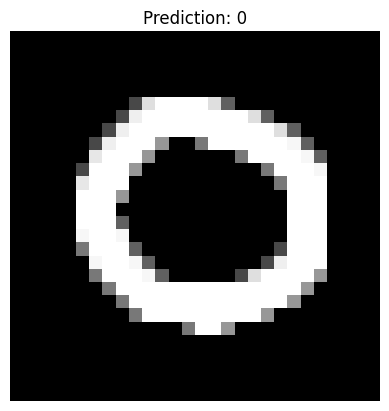

The image is probably a: 1


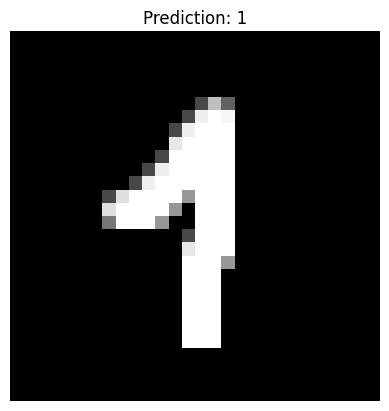

The image is probably a: 2


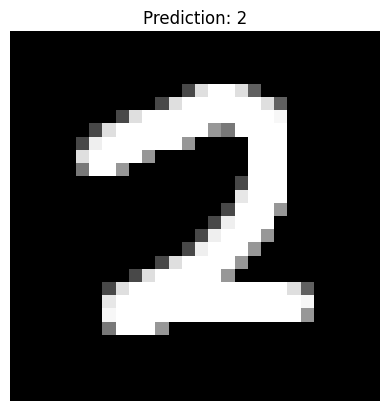

The image is probably a: 3


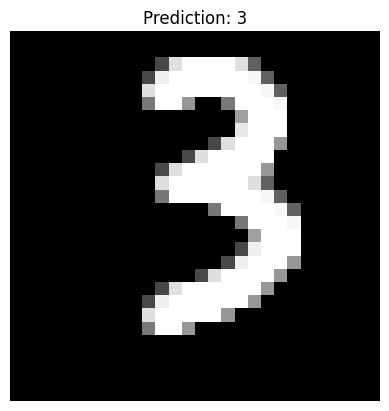

The image is probably a: 4


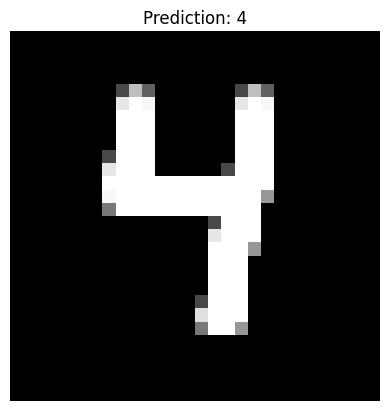

The image is probably a: 5


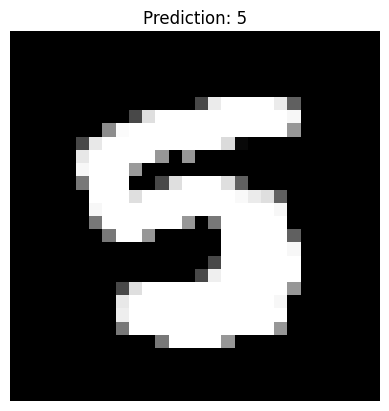

The image is probably a: 6


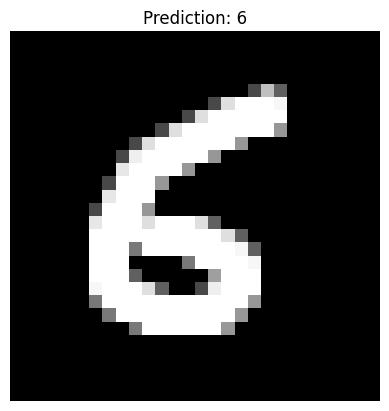

The image is probably a: 7


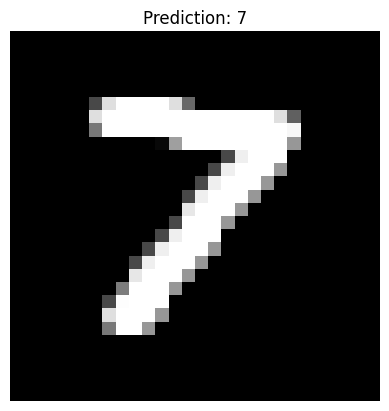

The image is probably a: 8


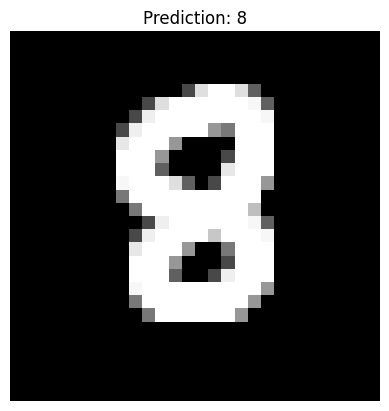

The image is probably a: 9


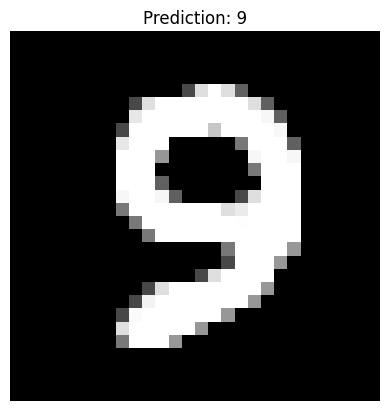

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def load_model_params(file_path):
    if os.path.exists(file_path):
        try:
            params = np.load(file_path)
            w_1 = params['w_1']
            b_1 = params['b_1']
            w_2 = params['w_2']
            b_2 = params['b_2']
            w_3 = params['w_3']
            b_3 = params['b_3']
            print(f"Parameters loaded from '{file_path}'.")
            return w_1, b_1, w_2, b_2, w_3, b_3
        except Exception as e:
            raise RuntimeError(f"Error loading parameters: {e}")
    else:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")

relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(X, w_1, b_1, w_2, b_2, w_3, b_3):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return A1, A2, A3

# Image preprocessing function
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Load as grayscale
    img_resized = cv2.resize(img, (28, 28))      # Resize to 28x28 pixels
    img_resized = img_resized / 255.0            # Normalize to range 0-1
    img_resized = img_resized.flatten()          # Flatten the image to 784 elements
    return img_resized.reshape(784, 1)           # Ensure shape is (784, 1)

#! Initializing the neural network parameters =============================================== 
# If you want to know which graph it corresponds to, look at the graph title.

#model_params_file = os.path.join('Weights_&_Bias', 'params_0.npz') # Final test accuracy: 67.2851%, Final train accuracy: 72.3632%
#model_params_file = os.path.join('Weights_&_Bias', 'params_1.npz') # Final test accuracy: 90.5761%, Final train accuracy: 97.9492%
#model_params_file = os.path.join('Weights_&_Bias', 'params_2.npz') # Final test accuracy: 44.2382%, Final train accuracy: 44.0429%
#model_params_file = os.path.join('Weights_&_Bias', 'params_3.npz') # Final test accuracy: 90.9175%, Final train accuracy: 100.0000%, created from params_1
#model_params_file = os.path.join('Weights_&_Bias', 'params_4.npz') # Final test accuracy: 91.2597%, Final train accuracy: 100.0000%, created from params_3
#model_params_file = os.path.join('Weights_&_Bias', 'params_5.npz') # Final test accuracy: 93.8964%, Final train accuracy: 100.0000%, created from params_4
#model_params_file = os.path.join('Weights_&_Bias', 'params_6.npz') # Final test accuracy: 94.8730%, Final train accuracy: 100.0000%, created from params_5
#model_params_file = os.path.join('Weights_&_Bias', 'params_7.npz') # Final test accuracy: 70.3125%, Final train accuracy: 100.0000%, L = 0.01, batch_size = 128, num_iterations = 10_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_8.npz') # Final test accuracy: 76.5625%, Final train accuracy: 100.0000%, L = 0.02, batch_size = 256, num_iterations = 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_9.npz') # Final test accuracy: 86.7188%, Final train accuracy: 99.1211%, L = 0.02, batch_size = 1024, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_10.npz') # Final test accuracy: 87.9883%, Final train accuracy: 96.7285% L = 0.03, batch_size = 2048, num_iterations= 3_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_11.npz') # Final test accuracy: 90.6982%, Final train accuracy: 98.9014% L = 0.03, batch_size = 4096, num_iterations= 6_000 (Iter 5600, Test accuracy: 90.7471%, Train accuracy: 98.6328%)
#model_params_file = os.path.join('Weights_&_Bias', 'params_12.npz') # Final test accuracy: 84.3750%, Final train accuracy: 100.0000% L = 0.02, batch_size = 512, num_iterations= 6_000 (Iter 4000, Test accuracy: 84.9609%, Train accuracy: 100.0000%)
#model_params_file = os.path.join('Weights_&_Bias', 'params_13.npz') # Final test accuracy: 93.6646%, Final train accuracy: 98.7671% L = 0.03, batch_size = 8_192, num_iterations= 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_14.npz') # Final test accuracy: 94.0552%, Final train accuracy: 99.7314% L = 0.08, batch_size = 8_192, num_iterations= 4_000
model_params_file = os.path.join('Weights_&_Bias', 'params_15.npz') # ""Final test accuracy: 96.0000%, Final train accuracy: 97.0000%"" L = 0.1, batch_size = 16_384, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_16.npz') # Final test accuracy: 96.4650%, Final train accuracy: 97.9550% L = 0.1, batch_size = 32_768, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_17.npz') # Final test accuracy: 96.9700%, Final train accuracy: 98.9100% L = 0.1, batch_size = 32_768, num_iterations= 3_000 created from params_16

#! Initializing the neural network parameters =============================================== 

w_1, b_1, w_2, b_2, w_3, b_3 = load_model_params(model_params_file)

# Prediction using the neural network
for i in range(10):
    image_path = f'digits/digitB{i}.png'
    processed_image = preprocess_image(image_path)

    # Forward propagation to get the prediction
    _, _, A3 = forward_prop(processed_image, w_1, b_1, w_2, b_2, w_3, b_3)
    prediction = np.argmax(A3, axis=0)  # Get the class with the highest probability

    print(f'The image is probably a: {prediction[0]}')

    # Visualize the processed image
    plt.imshow(processed_image.reshape(28, 28), cmap='gray')
    plt.title(f'Prediction: {prediction[0]}')
    plt.axis('off')
    plt.show()


In [51]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os

def load_model_params(file_path):
    if os.path.exists(file_path):
        try:
            params = np.load(file_path)
            w_1 = params['w_1']
            b_1 = params['b_1']
            w_2 = params['w_2']
            b_2 = params['b_2']
            w_3 = params['w_3']
            b_3 = params['b_3']
            print(f"Parameters loaded from '{file_path}'.")
            return w_1, b_1, w_2, b_2, w_3, b_3
        except Exception as e:
            raise RuntimeError(f"Error loading parameters: {e}")
    else:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")

relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(X, w_1, b_1, w_2, b_2, w_3, b_3):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return A1, A2, A3

#! Initializing the neural network parameters =============================================== 
# If you want to know which graph it corresponds to, look at the graph title.

#model_params_file = os.path.join('Weights_&_Bias', 'params_0.npz') # Final test accuracy: 67.2851%, Final train accuracy: 72.3632%
#model_params_file = os.path.join('Weights_&_Bias', 'params_1.npz') # Final test accuracy: 90.5761%, Final train accuracy: 97.9492%
#model_params_file = os.path.join('Weights_&_Bias', 'params_2.npz') # Final test accuracy: 44.2382%, Final train accuracy: 44.0429%
#model_params_file = os.path.join('Weights_&_Bias', 'params_3.npz') # Final test accuracy: 90.9175%, Final train accuracy: 100.0000%, created from params_1
#model_params_file = os.path.join('Weights_&_Bias', 'params_4.npz') # Final test accuracy: 91.2597%, Final train accuracy: 100.0000%, created from params_3
#model_params_file = os.path.join('Weights_&_Bias', 'params_5.npz') # Final test accuracy: 93.8964%, Final train accuracy: 100.0000%, created from params_4
#model_params_file = os.path.join('Weights_&_Bias', 'params_6.npz') # Final test accuracy: 94.8730%, Final train accuracy: 100.0000%, created from params_5
#model_params_file = os.path.join('Weights_&_Bias', 'params_7.npz') # Final test accuracy: 70.3125%, Final train accuracy: 100.0000%, L = 0.01, batch_size = 128, num_iterations = 10_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_8.npz') # Final test accuracy: 76.5625%, Final train accuracy: 100.0000%, L = 0.02, batch_size = 256, num_iterations = 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_9.npz') # Final test accuracy: 86.7188%, Final train accuracy: 99.1211%, L = 0.02, batch_size = 1024, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_10.npz') # Final test accuracy: 87.9883%, Final train accuracy: 96.7285% L = 0.03, batch_size = 2048, num_iterations= 3_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_11.npz') # Final test accuracy: 90.6982%, Final train accuracy: 98.9014% L = 0.03, batch_size = 4096, num_iterations= 6_000 (Iter 5600, Test accuracy: 90.7471%, Train accuracy: 98.6328%)
#model_params_file = os.path.join('Weights_&_Bias', 'params_12.npz') # Final test accuracy: 84.3750%, Final train accuracy: 100.0000% L = 0.02, batch_size = 512, num_iterations= 6_000 (Iter 4000, Test accuracy: 84.9609%, Train accuracy: 100.0000%)
#model_params_file = os.path.join('Weights_&_Bias', 'params_13.npz') # Final test accuracy: 93.6646%, Final train accuracy: 98.7671% L = 0.03, batch_size = 8_192, num_iterations= 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_14.npz') # Final test accuracy: 94.0552%, Final train accuracy: 99.7314% L = 0.08, batch_size = 8_192, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_15.npz') # ""Final test accuracy: 96.0000%, Final train accuracy: 97.0000%"" L = 0.1, batch_size = 16_384, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_16.npz') # Final test accuracy: 96.4650%, Final train accuracy: 97.9550% L = 0.1, batch_size = 32_768, num_iterations= 4_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_17.npz') # Final test accuracy: 96.9700%, Final train accuracy: 98.9100% L = 0.1, batch_size = 32_768, num_iterations= 3_000 created from params_16

#! Initializing the neural network parameters =============================================== 

#model_params_file = os.path.join('Weights_&_Bias', 'params_0.npz') # 66.42%
#model_params_file = os.path.join('Weights_&_Bias', 'params_1.npz') # 90.85%
#model_params_file = os.path.join('Weights_&_Bias', 'params_2.npz') # 43.26%
#model_params_file = os.path.join('Weights_&_Bias', 'params_3.npz') # 91.77%
#model_params_file = os.path.join('Weights_&_Bias', 'params_4.npz') # 92.10%
#model_params_file = os.path.join('Weights_&_Bias', 'params_5.npz') # 94.29%
#model_params_file = os.path.join('Weights_&_Bias', 'params_6.npz') # 96.02%
#model_params_file = os.path.join('Weights_&_Bias', 'params_7.npz') # 66.30%
#model_params_file = os.path.join('Weights_&_Bias', 'params_8.npz') # 75.95%
#model_params_file = os.path.join('Weights_&_Bias', 'params_9.npz') # 83.89%
#model_params_file = os.path.join('Weights_&_Bias', 'params_10.npz') # 87.89%
#model_params_file = os.path.join('Weights_&_Bias', 'params_11.npz') # 91.15%
#model_params_file = os.path.join('Weights_&_Bias', 'params_12.npz') # 79.89%
#model_params_file = os.path.join('Weights_&_Bias', 'params_13.npz') # 94.16%
#model_params_file = os.path.join('Weights_&_Bias', 'params_14.npz') # 94.62%
#model_params_file = os.path.join('Weights_&_Bias', 'params_15.npz') # 96.56%
#model_params_file = os.path.join('Weights_&_Bias', 'params_16.npz') # 97.48%
model_params_file = os.path.join('Weights_&_Bias', 'params_17.npz') # 98.28%

#mnist = fetch_openml('mnist_784', version=1)
#X, Y = mnist['data'] / 255.0, mnist['target'].astype(int)
#X = X.T

data = pd.read_csv('DATA/train.csv')
X, Y = data.iloc[:, 1:].values.T / 255, data.iloc[:, 0].values

w_1, b_1, w_2, b_2, w_3, b_3 = load_model_params(model_params_file)

_, _, A3 = forward_prop(X, w_1, b_1, w_2, b_2, w_3, b_3)
y_pred = np.argmax(A3, axis=0)

accuracy = accuracy_score(Y, y_pred)
print(f"Model accuracy on the MNIST dataset: {accuracy * 100:.2f}%")


Parameters loaded from 'Weights_&_Bias\params_15.npz'.
Model accuracy on the MNIST dataset: 96.64%
